In [25]:
import sys

In [26]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [27]:
import os
memory="10g"
pyspark_submit_args = ' --driver-memory ' + memory + ' --conf spark.driver.maxResultSize=10g' +  ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [28]:
os.environ["PYSPARK_SUBMIT_ARGS"]

' --driver-memory 10g --conf spark.driver.maxResultSize=10g pyspark-shell'

In [29]:
import findspark
findspark.init()

In [30]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',1)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','20G') 
conf.set('spark.executor.memory','7G') 

conf.set('spark.cores.max',19*4)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local")

In [31]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

# part 2

In [32]:
data=sc.pickleFile("/tmp/f/grouped_transofrmed").zipWithUniqueId().cache()

In [33]:
data.count()

219126

In [34]:
a=data.first()
a[0].head()

date  istrain  item_nbr  onpromotion  store_nbr  unit_sales  city  \
75   2013-01-02     True    820006           -1          9    2.385823    18   
76   2013-01-03     True    820006           -1          9    1.630416    18   
77   2013-01-04     True    820006           -1          9    1.892208    18   
1335 2013-01-05     True    820006           -1          9    2.715092    18   
1336 2013-01-06     True    820006           -1          9    2.571772    18   

      state type  cluster  family  class  perishable  
75       12    1        6      24   2304           1  
76       12    1        6      24   2304           1  
77       12    1        6      24   2304           1  
1335     12    1        6      24   2304           1  
1336     12    1        6      24   2304           1

In [35]:
import cPickle as pickle
states,cities,families,types = pickle.load(open("aux_info_map.pkl"))
cat_mean = pickle.load(open("cat_mean_series.pkl"))

In [36]:
holiday=pd.read_csv("../input/holidays_events.csv", date_parser=lambda x: pd.datetime.strptime(x, '%Y-%m-%d'))
country_holiday=set(holiday[holiday['locale']=='National']['date'])
state_holiday=holiday[holiday['locale']=='Regional']
state_holiday.loc[:,'locale_name']=state_holiday['locale_name'].map(lambda u: states[u]) 
state_holiday=set(state_holiday[['date','locale_name']].apply(lambda u: tuple(u.values),axis=1) )
locale_holiday=holiday[holiday['locale']=='Local']
locale_holiday.loc[:,'locale_name']=locale_holiday['locale_name'].map(lambda u: cities[u]) 
locale_holiday=set(locale_holiday[['date','locale_name']].apply(lambda u: tuple(u.values),axis=1) )
locale_holiday=set([( pd.datetime.strptime(u, '%Y-%m-%d'),v) for u,v in locale_holiday])
state_holiday=set([( pd.datetime.strptime(u, '%Y-%m-%d'),v) for u,v in state_holiday])
country_holiday=set([ pd.datetime.strptime(u, '%Y-%m-%d') for u in country_holiday])
len(state_holiday),len(locale_holiday),len(country_holiday)

/home/spark/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(24, 151, 168)

In [37]:
oil=pd.read_csv("../input/oil.csv",parse_dates=['date'], date_parser=lambda x: pd.datetime.strptime(x, '%Y-%m-%d'),index_col=0)
dr=pd.date_range(oil.index.min(),oil.index.max())
newoil=pd.DataFrame(index=dr)
newoil['dcoilwtico']=oil['dcoilwtico']
newoil=newoil.fillna(method='ffill').fillna(method='backfill').reset_index()
oil=newoil.set_index('index').to_dict()['dcoilwtico']
len(oil)

1704

# sales related

In [14]:
def get_sales(rdd, lag=1):
    def f(df_idx,lag):
        df,idx=df_idx
        #df=df[df['istrain']]
        s=df[['date']]
        s['date']=s['date']+pd.Timedelta(days=lag)
        s['unit_sales']=df['unit_sales']*(1+1.1180339887498949*df['perishable']).astype(np.float32)
        return idx,s.set_index("date")
    return "sales_lag_{}".format(lag), rdd.map(lambda u: f(u,lag=lag)) 

In [15]:
def h():
    for i in range(1,8):
        name,s=get_sales(data,lag=i)
        print name
        !hadoop fs -rmr {"/tmp/f/s/"+name}
        s.saveAsPickleFile("/tmp/f/s/"+name)

In [16]:
h()

sales_lag_1
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 14:43:21 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/sales_lag_1
sales_lag_2
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 14:46:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/sales_lag_2
sales_lag_3
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 14:50:11 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/sales_lag_3
sales_lag_4
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 14:53:35 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/sales_lag_4
sales_lag_5
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 14:56:57 INFO fs.TrashPolicyDefault: Namen

In [17]:
def f(df_idx,period):
    df,idx=df_idx
    s=df[['date']]
    s['date']=s['date']+pd.Timedelta(days=1)
    s['unit_sales']=df['unit_sales']*(1+1.1180339887498949*df['perishable']).astype(np.float32)
    s=s.set_index("date")
    oldindex=s.index
    d1=s.index.min();d2=s.index.max()
    s=s.reindex(pd.date_range(d1,d2))
    s['unit_sales']=pd.rolling_mean(s['unit_sales'], window=period,min_periods=int(period/2)).astype(np.float32)
    s=s.loc[oldindex]
    return idx,s
def get_sales_ma(rdd, period=3):
    return "sales_ma_{}".format(period), rdd.map(lambda u: f(u,period=period)) 

In [18]:
def h():
    for i in [3,7,14,28,56,112,224]:
        name,s=get_sales_ma(data,period=i)
        print name
        !hadoop fs -rmr {"/tmp/f/s/"+name}
        s.saveAsPickleFile("/tmp/f/s/"+name)

In [19]:
h()

sales_ma_3
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 15:07:40 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/sales_ma_3
sales_ma_7
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 15:11:25 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/sales_ma_7
sales_ma_14
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 15:15:04 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/sales_ma_14
sales_ma_28
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 15:18:41 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/sales_ma_28
sales_ma_56
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 15:22:31 INFO fs.TrashPolicyDefault: Namenode 

In [20]:
def f(df_idx,period,lag):
    df,idx=df_idx
    s=df[['date']]
    s['date']=s['date']+pd.Timedelta(days=lag)
    s['unit_sales']=df['unit_sales']*(1+1.1180339887498949*df['perishable']).astype(np.float32)
    s=s.set_index("date")
    oldindex=s.index
    
    d1=s.index.min();d2=s.index.max()
    s=s.reindex(pd.date_range(d1,d2))
    s['weekday']=s.index.weekday
    lst=[]
    for wd in set(s['weekday']):
        subdf=s[s['weekday']==wd]
        a=pd.rolling_mean(subdf['unit_sales'], window=period,min_periods=int(period/2)).astype(np.float32)
        lst.append(a)
    s['unit_sales']=pd.concat(lst,axis=0).astype(np.float32)
    s=s.loc[oldindex].drop('weekday',axis=1)
    return idx,s
def get_sales_seasonal_week_ma(rdd, period=2,lag=1):
    return "sales_week_season_ma_p{}_l{}".format(period,lag), rdd.map(lambda u: f(u,period=period,lag=lag)) 

In [21]:
def h():
    for l in range(1,8):
        for p in [2,3,4,7,13]:
            name,s=get_sales_seasonal_week_ma(data,period=p,lag=l)
            print name
            !hadoop fs -rmr {"/tmp/f/s/"+name}
            s.saveAsPickleFile("/tmp/f/s/"+name)


In [22]:
h()            

sales_week_season_ma_p2_l1
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/f/s/sales_week_season_ma_p2_l1': No such file or directory
sales_week_season_ma_p3_l1
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/f/s/sales_week_season_ma_p3_l1': No such file or directory
sales_week_season_ma_p4_l1
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/f/s/sales_week_season_ma_p4_l1': No such file or directory
sales_week_season_ma_p7_l1
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/f/s/sales_week_season_ma_p7_l1': No such file or directory
sales_week_season_ma_p13_l1
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/f/s/sales_week_season_ma_p13_l1': No such file or directory
sales_week_season_ma_p2_l2
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/f/s/sales_week_season_ma_p2_l2': No such file or directory
sales_week_season_ma_p3_l2
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/f/s/sales_week_season_ma_p3_l2': No such file or directory
sale

# oil related

In [23]:
np.min(oil.keys()),np.max(oil.keys())

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-31 00:00:00'))

In [24]:
def f(df_idx,lag):
    df,idx=df_idx
    s=df[['date']]
    s['oil']=s['date'].map(lambda u: oil[u]).astype(np.float32)
    s['date']=s['date']+pd.Timedelta(days=lag)
    return idx,s.set_index("date")
def get_oil(rdd, lag=0):
    return "oil_lag_{}".format(lag), rdd.map(lambda u: f(u,lag=lag)) 

In [25]:
def h():
    for l in [0,3,6,10]:
        name,s=get_oil(data,lag=l)
        print name
        !hadoop fs -rmr {"/tmp/f/s/"+name}
        s.saveAsPickleFile("/tmp/f/s/"+name)

In [26]:
h()

oil_lag_0
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 17:56:05 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/oil_lag_0
oil_lag_3
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 17:59:36 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/oil_lag_3
oil_lag_6
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/f/s/oil_lag_6': No such file or directory
oil_lag_10
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/f/s/oil_lag_10': No such file or directory


In [27]:
def f(df_idx,oildiff):
    df,idx=df_idx
    s=df[['date']]
    s['oil']=s['date'].map(lambda u: oildiff[u]).astype(np.float32)
    return idx,s.set_index("date")
def get_oil_diff(rdd, period=1):
    oildiff=pd.Series(oil).diff(period).to_dict()
    return "oil_d{}".format(period), rdd.map(lambda u: f(u,oildiff)) 

In [28]:
def h():
    for l in [1,3,5,10,15]:
        name,s=get_oil_diff(data,period=l)
        print name
        !hadoop fs -rmr {"/tmp/f/s/"+name}
        s.saveAsPickleFile("/tmp/f/s/"+name)


In [29]:
h()

oil_d1
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 18:10:18 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/oil_d1
oil_d3
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 18:12:15 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/oil_d3
oil_d5
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 18:14:15 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/oil_d5
oil_d10
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/f/s/oil_d10': No such file or directory
oil_d15
rmr: DEPRECATED: Please use 'rm -r' instead.
rmr: `/tmp/f/s/oil_d15': No such file or directory


# cat_mean related

In [15]:
cat_mean.keys()

['city', 'item_nbr', 'cluster', 'store_nbr', 'state', 'type', 'class']

In [16]:
for key in cat_mean.keys():
    print key, cat_mean[key].shape

city (1700, 22)
item_nbr (1700, 4036)
cluster (1700, 17)
store_nbr (1700, 54)
state (1700, 16)
type (1700, 5)
class (1700, 334)


In [17]:
cat_mean['city'][:10].to_dict().keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [18]:
data.first()[0].loc[77]['date'] in cat_mean['city'][0]

True

In [19]:
def f(df_idx,key,cat_dict, period):
    df,idx=df_idx
    s=df[['date',key]]
    def g(u):
        d,k=u.values
        if k in cat_dict and d in cat_dict[k]:
            return cat_dict[k][d]
        else:
            return np.nan
    s[key]=s.apply(g,axis=1).astype(np.float32)      
    s['date']=s['date']+pd.Timedelta(days=1)
    s=s.set_index("date")
    oldindex=s.index
    d1=s.index.min();d2=s.index.max()
    s=s.reindex(pd.date_range(d1,d2))
    s[key]=pd.rolling_mean(s[key], window=period,min_periods=int(period/2)).astype(np.float32)
    s=s.loc[oldindex]
    return idx,s

def get_cat_lag(key, rdd, period=1):
    cat_dict=cat_mean[key].to_dict()
    return "{}_lag1_m{}".format(key, period), rdd.map(lambda u: f(u,key,cat_dict,period=period))

In [33]:
def h():
    for key in ['city', 'cluster', 'store_nbr', 'state', 'type', 'class', 'item_nbr']: #cat_mean.keys():
        print key, cat_mean[key].shape
        for l in [35]:
            name,s=get_cat_lag(key,data,period=l)
            print name
            !hadoop fs -rmr {"/tmp/f/s/"+name}
            s.saveAsPickleFile("/tmp/f/s/"+name)    


In [34]:
h()

city (1700, 22)
city_lag1_m35
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/10 17:06:33 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/city_lag1_m35
cluster (1700, 17)
cluster_lag1_m35
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/10 17:22:10 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/cluster_lag1_m35
store_nbr (1700, 54)
store_nbr_lag1_m35
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/10 17:34:43 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/store_nbr_lag1_m35
state (1700, 16)
state_lag1_m35
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/10 17:41:02 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/state_lag1_m35
t

Py4JJavaError: An error occurred while calling o287.saveAsObjectFile.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 756 in stage 16.0 failed 4 times, most recent failure: Lost task 756.3 in stage 16.0 (TID 8305, 192.168.0.26, executor 109): java.net.SocketException: Connection reset
	at java.net.SocketInputStream.read(SocketInputStream.java:210)
	at java.net.SocketInputStream.read(SocketInputStream.java:141)
	at java.io.BufferedInputStream.fill(BufferedInputStream.java:246)
	at java.io.BufferedInputStream.read(BufferedInputStream.java:265)
	at java.io.DataInputStream.readInt(DataInputStream.java:387)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2043)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2075)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply$mcV$sp(PairRDDFunctions.scala:1151)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1096)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1096)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1096)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply$mcV$sp(PairRDDFunctions.scala:1070)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1035)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1035)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1035)
	at org.apache.spark.rdd.SequenceFileRDDFunctions$$anonfun$saveAsSequenceFile$1.apply$mcV$sp(SequenceFileRDDFunctions.scala:101)
	at org.apache.spark.rdd.SequenceFileRDDFunctions$$anonfun$saveAsSequenceFile$1.apply(SequenceFileRDDFunctions.scala:86)
	at org.apache.spark.rdd.SequenceFileRDDFunctions$$anonfun$saveAsSequenceFile$1.apply(SequenceFileRDDFunctions.scala:86)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.SequenceFileRDDFunctions.saveAsSequenceFile(SequenceFileRDDFunctions.scala:86)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsObjectFile$1.apply$mcV$sp(RDD.scala:1516)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsObjectFile$1.apply(RDD.scala:1516)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsObjectFile$1.apply(RDD.scala:1516)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.saveAsObjectFile(RDD.scala:1513)
	at org.apache.spark.api.java.JavaRDDLike$class.saveAsObjectFile(JavaRDDLike.scala:565)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsObjectFile(JavaRDDLike.scala:45)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.net.SocketException: Connection reset
	at java.net.SocketInputStream.read(SocketInputStream.java:210)
	at java.net.SocketInputStream.read(SocketInputStream.java:141)
	at java.io.BufferedInputStream.fill(BufferedInputStream.java:246)
	at java.io.BufferedInputStream.read(BufferedInputStream.java:265)
	at java.io.DataInputStream.readInt(DataInputStream.java:387)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [24]:
def f(df_idx,key,cat_dict, period):
    df,idx=df_idx
    s=df[['date',key]]
    def g(u):
        d,k=u.values
        if k in cat_dict and d in cat_dict[k]:
            return cat_dict[k][d]
        else:
            return np.nan
    s[key]=s.apply(g,axis=1).astype(np.float32)      
    s['date']=s['date']+pd.Timedelta(days=1)
    s=s.set_index("date")
    oldindex=s.index
    d1=s.index.min();d2=s.index.max()
    s=s.reindex(pd.date_range(d1,d2))
    s[key]=pd.rolling_mean(s[key], window=period,min_periods=int(period/2)).astype(np.float32)
    s=s.loc[oldindex]
    return idx,s

def get_cat_lag(key, rdd, period=1):
    bc_cat_dict=sc.broadcast(cat_mean[key].to_dict())
    return "{}_lag1_m{}".format(key, period), rdd.map(lambda u: f(u,key,bc_cat_dict.value,period=period))

In [15]:
def h():
    for key in [ 'item_nbr']: #cat_mean.keys():
        print key, cat_mean[key].shape
        for l in [35]:
            name,s=get_cat_lag(key,data,period=l)
            print name
            !hadoop fs -rmr {"/tmp/f/s/"+name}
            s.saveAsPickleFile("/tmp/f/s/"+name)    
h()

item_nbr (1700, 4036)
item_nbr_lag1_m35
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/11 05:14:24 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/item_nbr_lag1_m35


In [19]:
data.map(lambda u: u[0]['type'].value_counts().reset_index().values).flatMap(lambda u:tuple(u)).reduceByKey(lambda u,v: u+v).collect()

[(u'4', 8328295),
 (u'2', 26845077),
 (u'0', 27392606),
 (u'3', 47924858),
 (u'1', 18376668)]

In [22]:
cat_mean['type'].index.dtype 

dtype('<M8[ns]')

In [31]:
cat_mean['type'].head().to_dict()

{0: {Timestamp('2013-01-01 00:00:00'): nan,
  Timestamp('2013-01-02 00:00:00'): 2.456144332885742,
  Timestamp('2013-01-03 00:00:00'): 2.1772682666778564,
  Timestamp('2013-01-04 00:00:00'): 2.216198205947876,
  Timestamp('2013-01-05 00:00:00'): 2.452411413192749},
 1: {Timestamp('2013-01-01 00:00:00'): nan,
  Timestamp('2013-01-02 00:00:00'): 2.0215578079223633,
  Timestamp('2013-01-03 00:00:00'): 1.8053739070892334,
  Timestamp('2013-01-04 00:00:00'): 1.7339529991149902,
  Timestamp('2013-01-05 00:00:00'): 1.9260121583938599},
 2: {Timestamp('2013-01-01 00:00:00'): nan,
  Timestamp('2013-01-02 00:00:00'): 1.776826024055481,
  Timestamp('2013-01-03 00:00:00'): 1.6724574565887451,
  Timestamp('2013-01-04 00:00:00'): 1.583135962486267,
  Timestamp('2013-01-05 00:00:00'): 1.7539925575256348},
 3: {Timestamp('2013-01-01 00:00:00'): 1.3504838943481445,
  Timestamp('2013-01-02 00:00:00'): 1.9515334367752075,
  Timestamp('2013-01-03 00:00:00'): 1.7927109003067017,
  Timestamp('2013-01-04 00:

In [32]:
data.first()[0].head()

date  istrain  item_nbr  onpromotion  store_nbr  unit_sales  city  \
75   2013-01-02     True    820006           -1          9    2.385823    18   
76   2013-01-03     True    820006           -1          9    1.630416    18   
77   2013-01-04     True    820006           -1          9    1.892208    18   
1335 2013-01-05     True    820006           -1          9    2.715092    18   
1336 2013-01-06     True    820006           -1          9    2.571772    18   

      state type  cluster  family  class  perishable  
75       12    1        6      24   2304           1  
76       12    1        6      24   2304           1  
77       12    1        6      24   2304           1  
1335     12    1        6      24   2304           1  
1336     12    1        6      24   2304           1

In [39]:
def f(df_idx,key,cat_dict, period):
    df,idx=df_idx
    s=df[['date',key]]
    def g(u):
        d,k=u.values
        if k in cat_dict and d in cat_dict[k]:
            return cat_dict[k][d]
        else:
            return np.nan
    s[key]=s.apply(g,axis=1).astype(np.float32)      
    s['date']=s['date']+pd.Timedelta(days=1)
    s=s.set_index("date")
    oldindex=s.index
    d1=s.index.min();d2=s.index.max()
    s=s.reindex(pd.date_range(d1,d2))
    s[key]=pd.rolling_mean(s[key], window=period,min_periods=int(period/2)).astype(np.float32)
    s=s.loc[oldindex]
    return idx,s

def get_cat_lag(key, rdd, period=1):
    a=cat_mean[key]
    a.columns=a.columns.astype(np.str)
    bc_cat_dict=sc.broadcast(a.to_dict())
    return "{}_lag1_m{}".format(key, period), rdd.map(lambda u: f(u,key,bc_cat_dict.value,period=period))

In [40]:
def h():
    for key in [ 'type']: #cat_mean.keys():
        print key, cat_mean[key].shape
        for l in [35]:
            name,s=get_cat_lag(key,data,period=l)
            print name
            !hadoop fs -rmr {"/tmp/f/s/"+name}
            s.saveAsPickleFile("/tmp/f/s/"+name)    
h()

type (1700, 5)
type_lag1_m35
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/11 21:18:46 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/type_lag1_m35


In [53]:
sc.pickleFile('/tmp/f/s/type_lag1_m35').take(3)[-1][1].sum()

type    3133.834961
dtype: float32

In [5]:
0.7*1+0.3*1.25

1.075

Populating the interactive namespace from numpy and matplotlib


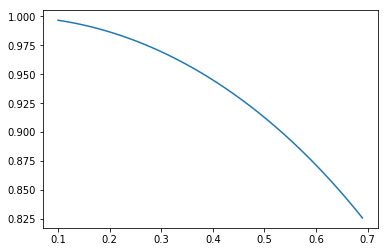

In [20]:
import numpy as np
import pandas as pd
%pylab inline
l=[]
for i in range(60):
    a=0.1+i*0.01
    l.append([a, np.sqrt(1-(a**2)*1.075/1.61)])
l=np.array(l)
plt.plot(l[:,0],l[:,1])

In [24]:
pd.DataFrame(l)[30:50]

0         1
30  0.40  0.945076
31  0.41  0.942210
32  0.42  0.939264
33  0.43  0.936238
34  0.44  0.933131
35  0.45  0.929941
36  0.46  0.926668
37  0.47  0.923312
38  0.48  0.919870
39  0.49  0.916343
40  0.50  0.912729
41  0.51  0.909027
42  0.52  0.905237
43  0.53  0.901356
44  0.54  0.897384
45  0.55  0.893320
46  0.56  0.889162
47  0.57  0.884909
48  0.58  0.880560
49  0.59  0.876112

# holiday related

In [12]:
type(list(country_holiday)[0])

datetime.datetime

In [13]:
def f(df_idx):
    df,idx=df_idx
    s=df[['date']]
    def g(u):
        state=u['state']
        city=u['city']
        d=u['date']
        return (d in country_holiday) or ((d,state) in state_holiday) or  ((d,city) in locale_holiday)
    s['isholiday']=df.apply(g,axis=1).astype(np.float32)      
    s=s.set_index("date")
    return idx,s

def get_holiday(rdd):
    return "{}_days".format("holiday"), rdd.map(lambda u: f(u))

In [14]:
def h():
    name,s=get_holiday(data)
    print name
    !hadoop fs -rmr {"/tmp/f/s/"+name}
    s.saveAsPickleFile("/tmp/f/s/"+name)     

In [15]:
h()

holiday_days
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 21:56:09 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/holiday_days


In [16]:
def fillna_holiday_forward(s):
    lst=[]
    curr_holiday=None
    for i in range(len(s)):
        if s.iloc[i]:
            curr_holiday=i
        if curr_holiday is not None and curr_holiday <> i:
            lst.append(np.exp(-0.231*(i-curr_holiday)))
        else:
            lst.append(0)
    return pd.Series(lst,index=s.index)

In [17]:
def f(df_idx):
    df,idx=df_idx
    s=df[['date']]
    state=df.iloc[0]['state']
    city=df.iloc[0]['city']
    
    def g(u):
        d=u
        return (d in country_holiday) or ((d,state) in state_holiday) or  ((d,city) in locale_holiday)
    s=s.set_index("date").sort_index()
    oldindex=s.index
    d1=s.index.min()-pd.Timedelta(days=10);d2=s.index.max()+pd.Timedelta(days=10)
    s=s.reindex(pd.date_range(d1,d2))
    s['forward_holiday']=s.index.map(g).astype(np.float32)   
    s["forward_holiday"]=np.round(fillna_holiday_forward(s['forward_holiday']).astype(np.float32),3)
    s=s.loc[oldindex]
    return idx,s


def get_holiday_smooth_forward(rdd):
    return "{}_smooth_forward".format("holiday"), rdd.map(lambda u: f(u))

In [18]:
def h():
    name,s=get_holiday_smooth_forward(data)
    print name
    !hadoop fs -rmr {"/tmp/f/s/"+name}
    s.saveAsPickleFile("/tmp/f/s/"+name)  

In [19]:
h()

holiday_smooth_forward
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 22:01:44 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/holiday_smooth_forward


In [20]:
def fillna_holiday_backword(s):
    lst=[]
    curr_holiday=None
    for i in range(len(s)-1,-1,-1):
        if s.iloc[i]:
            curr_holiday=i
        if curr_holiday is not None:
            lst.append(np.exp(0.231*(i-curr_holiday)))
        else:
            lst.append(0)
    lst=list(reversed(lst))
    return pd.Series(lst,index=s.index)

In [21]:
def f(df_idx):
    df,idx=df_idx
    s=df[['date']]
    state=df.iloc[0]['state']
    city=df.iloc[0]['city']
    
    def g(u):
        d=u
        return (d in country_holiday) or ((d,state) in state_holiday) or  ((d,city) in locale_holiday)
    s=s.set_index("date").sort_index()
    oldindex=s.index
    d1=s.index.min()-pd.Timedelta(days=10);d2=s.index.max()+pd.Timedelta(days=10)
    s=s.reindex(pd.date_range(d1,d2))
    s['backward_holiday']=s.index.map(g).astype(np.float32)   
    s["backward_holiday"]=np.round(fillna_holiday_backword(s['backward_holiday']).astype(np.float32),3)
    s=s.loc[oldindex]
    return idx,s


def get_holiday_smooth_backword(rdd):
    return "{}_smooth_backward".format("holiday"), rdd.map(lambda u: f(u))

In [22]:
def h():
    name,s=get_holiday_smooth_backword(data)
    print name
    !hadoop fs -rmr {"/tmp/f/s/"+name}
    s.saveAsPickleFile("/tmp/f/s/"+name)  

In [23]:
h()

holiday_smooth_backward
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 22:03:30 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/holiday_smooth_backward


# wage days

In [24]:
def fillna_wage_forward(s):
    lst=[]
    curr_holiday=None
    for i in range(len(s)):
        if s.iloc[i]:
            curr_holiday=i
        if curr_holiday is not None :
            lst.append((i-curr_holiday)/15.0)
        else:
            lst.append(0)
    return pd.Series(lst,index=s.index)

In [25]:
import calendar
def f(df_idx):
    df,idx=df_idx
    s=df[['date']]
    
    def g(d):
        return (d.day==15) or  d.day==calendar.monthrange(d.year,d.month)[1]
    s=s.set_index("date").sort_index()
    oldindex=s.index
    d1=s.index.min()-pd.Timedelta(days=10);d2=s.index.max()+pd.Timedelta(days=10)
    s=s.reindex(pd.date_range(d1,d2))
    s['forward_wage']=s.index.map(g).astype(np.float32)   
    s["forward_wage"]=np.round(fillna_wage_forward(s['forward_wage']).astype(np.float32),3)
    s=s.loc[oldindex]
    return idx,s


def get_wage_smooth_backword(rdd):
    return "{}_smooth_backward".format("wage"), rdd.map(lambda u: f(u))

In [26]:
def h():
    name,s=get_wage_smooth_backword(data)
    print name
    !hadoop fs -rmr {"/tmp/f/s/"+name}
    s.saveAsPickleFile("/tmp/f/s/"+name)  

In [27]:
h()

wage_smooth_backward
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 22:05:15 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/wage_smooth_backward


# year

# make target

In [28]:
def f(df_idx):
    df,idx=df_idx
    s=df[['date']]
    s['unit_sales']=df['unit_sales']*(1+1.1180339887498949*df['perishable']).astype(np.float32)
    s=s.set_index("date").sort_index()

    d1=s.index.min();d2=s.index.max()+pd.Timedelta(days=16)
    sdict=s.reindex(pd.date_range(d1,d2))['unit_sales'].to_dict()
    def g(today):
        lst=[]
        for d in pd.date_range(today, today+pd.Timedelta(days=15)):
            lst.append(sdict[d])
        assert (len(lst))==16
        return np.array(lst,dtype=np.float32)
    s['target']=s.index.map(g)
    return idx,s.drop(['unit_sales'],axis=1)


def get_targets(rdd):
    return "{}".format("targets"), rdd.map(lambda u: f(u))

In [29]:
def h():
    name,s=get_targets(data)
    print name
    !hadoop fs -rmr {"/tmp/f/s/"+name}
    s.saveAsPickleFile("/tmp/f/s/"+name)  

In [30]:
h()

targets
rmr: DEPRECATED: Please use 'rm -r' instead.
17/11/09 22:06:51 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/f/s/targets


# stop

In [16]:
sc.stop()